## Approach 1

In [23]:
# Notebook 4 — Sales Forecasting (simple LR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", 200)

In [24]:
# Using my prepared files
sales = pd.read_csv("../data/interim/sales_joined_cleaned.csv", parse_dates=["sale_date"])
feedback = pd.read_csv("../data/processed/feedback_scored.csv")  # from Notebook 5

# Making sure dates exist for grouping
if "sale_date" in feedback.columns:
    feedback["sale_date"] = pd.to_datetime(feedback["sale_date"])
else:
    # If your feedback file used a different name by accident, fail loudly
    raise ValueError("feedback_scored.csv must contain a 'sale_date' column.")

In [25]:
# --- Monthly sales, churn, basic counts ---
monthly_sales = (
    sales
    .groupby(pd.Grouper(key="sale_date", freq="MS"))  # Month start for clean x-axis
    .agg(
        total_sales=("total_value", "sum"),
        churn_rate=("churn", "mean"),
        orders=("sale_id", "count"),
        customers=("customer_id", "nunique"),
        aov=("total_value", "mean"),
    )
    .reset_index()
)

# Monthly numeric sentiment (auto-pick only numeric columns to avoid dtype errors)
sent_num_cols = feedback.select_dtypes(include="number").columns.tolist()
sent_monthly = (
    feedback
    .groupby(pd.Grouper(key="sale_date", freq="MS"))[sent_num_cols]
    .mean()
    .reset_index()
)

# Merge together
data = (
    monthly_sales
    .merge(sent_monthly, on="sale_date", how="left")
    .sort_values("sale_date")
    .fillna(method="ffill")  # forward-filling sentiment gaps
    .fillna(0.0)
)

print(data.tail(3))

    sale_date  total_sales  churn_rate  orders  customers           aov  \
45 2023-10-01      7015400    0.238710     155        149  45260.645161   
46 2023-11-01      7126900    0.290698     172        166  41435.465116   
47 2023-12-01      7597450    0.253086     162        153  46897.839506   

         neg       neu       pos  compound     churn  
45  0.119716  0.541413  0.338871  0.229194  0.238710  
46  0.137262  0.556663  0.306076  0.173883  0.290698  
47  0.121056  0.555395  0.323549  0.198140  0.253086  


/var/folders/31/f5jzh4490fgd72bczq3kgfzh0000gn/T/ipykernel_1489/885829408.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")  # forward-filling sentiment gaps


In [26]:
# Building 'monthly' with required columns for later cells ---

# 1) Starting with my existing monthly aggregate
src = monthly_sales.copy()

# 2) Cleaning and normalizeing dates and basic columns
src["sale_date"] = pd.to_datetime(src["sale_date"])
src = src.sort_values("sale_date").reset_index(drop=True)

# creating safe fallbacks so models still run
for col, default in [("orders", np.nan), ("customers", np.nan), ("aov", np.nan), ("churn_rate", np.nan)]:
    if col not in src.columns:
        src[col] = default

# 3) Creating the final 'monthly' dataset with time features
monthly = src.copy()
monthly["t"] = np.arange(1, len(monthly) + 1)                # time index
monthly["month"] = monthly["sale_date"].dt.month             # month number

# One-hot for month (ensuring all 12 exist)
month_dummies = pd.get_dummies(monthly["month"], prefix="M")
for m in range(1, 13):
    col = f"M_{m}"
    if col not in month_dummies.columns:
        month_dummies[col] = 0
# Order columns M_1..M_12
month_dummies = month_dummies[[f"M_{m}" for m in range(1, 13)]]

monthly = pd.concat([monthly, month_dummies], axis=1)

# 4) Sanity check so Cell 4 won't assert
required = {"sale_date", "total_sales", "t", "month"}
missing = required - set(monthly.columns)
assert not missing, f"`monthly` is missing: {missing}"

print("monthly columns:", list(monthly.columns))
display(monthly.head())

monthly columns: ['sale_date', 'total_sales', 'churn_rate', 'orders', 'customers', 'aov', 't', 'month', 'M_1', 'M_2', 'M_3', 'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'M_9', 'M_10', 'M_11', 'M_12']


,sale_date,total_sales,churn_rate,orders,customers,aov,t,month,M_1,M_2,M_3,M_4,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12
0,2020-01-01,7626450,0.274648,142,135,53707.394366,1,1,True,False,False,False,False,False,False,False,False,False,False,False
1,2020-02-01,8017900,0.254144,181,175,44297.790055,2,2,False,True,False,False,False,False,False,False,False,False,False,False
2,2020-03-01,9833950,0.215789,190,176,51757.631579,3,3,False,False,True,False,False,False,False,False,False,False,False,False
3,2020-04-01,8179950,0.269939,163,154,50183.742331,4,4,False,False,False,True,False,False,False,False,False,False,False,False
4,2020-05-01,8646400,0.231183,186,176,46486.021505,5,5,False,False,False,False,True,False,False,False,False,False,False,False


In [27]:
# Keeping it simple: time index, month dummies, and a couple of stable exogenous signals
data["t"] = np.arange(len(data))  # linear trend

# month-of-year one-hot (seasonality)
data["month"] = data["sale_date"].dt.month
month_ohe = pd.get_dummies(data["month"], prefix="m", drop_first=True)

# a small, safe sentiment set if present
cand_sent = [c for c in ["compound", "neg", "neu", "pos"] if c in data.columns]

feature_cols = ["t", "churn_rate", "orders", "customers", "aov"] + cand_sent
X_full = pd.concat([data[feature_cols], month_ohe], axis=1)
y_full = data["total_sales"].astype(float)

print("Features used:", list(X_full.columns))
print("Shape:", X_full.shape, "| months:", len(data))

Features used: ['t', 'churn_rate', 'orders', 'customers', 'aov', 'compound', 'neg', 'neu', 'pos', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']
Shape: (48, 20) | months: 48


In [28]:
split_date = pd.Timestamp("2023-01-01")
train_mask = data["sale_date"] < split_date
test_mask  = data["sale_date"] >= split_date

X_train, y_train = X_full.loc[train_mask], y_full.loc[train_mask]
X_test,  y_test  = X_full.loc[test_mask],  y_full.loc[test_mask]

print("Train months:", X_train.shape[0], "| Test months:", X_test.shape[0])

Train months: 36 | Test months: 12


Linear Regression | MAE: 52,431 | RMSE: 70,805 | R²: 0.995


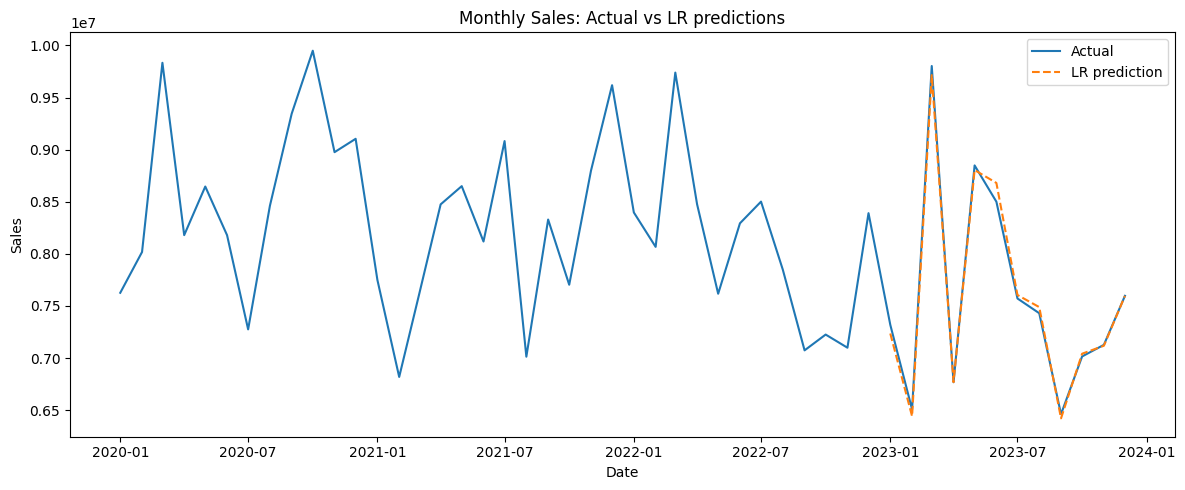

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"Linear Regression | MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(data["sale_date"], data["total_sales"], label="Actual")
plt.plot(data.loc[test_mask, "sale_date"], y_pred, "--", label="LR prediction")
plt.title("Monthly Sales: Actual vs LR predictions")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.tight_layout(); plt.show()

Random Forest | MAE: 310,189 | RMSE: 397,959 | R²: 0.828


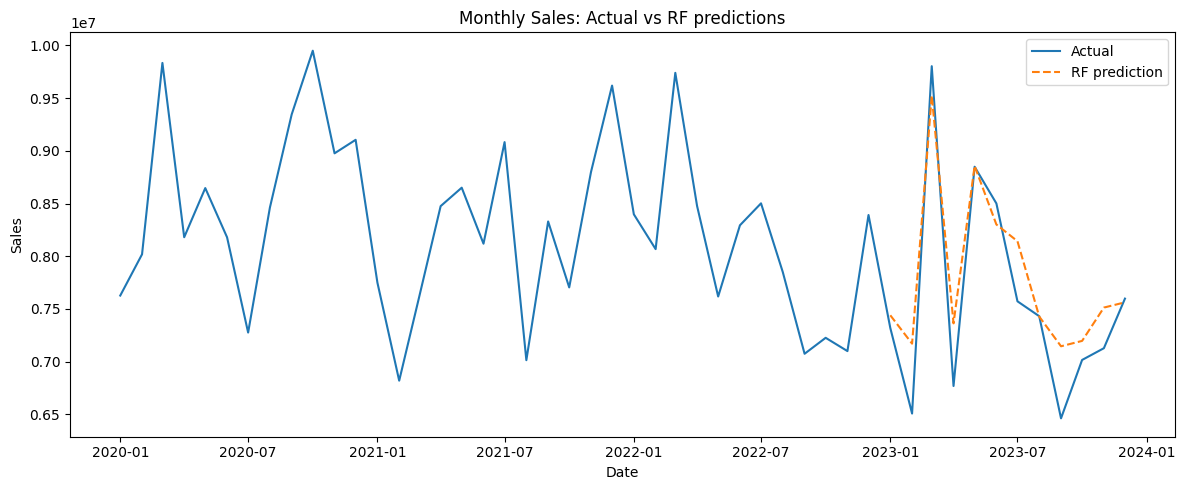

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"Random Forest | MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")

plt.figure(figsize=(12,5))
plt.plot(data["sale_date"], data["total_sales"], label="Actual")
plt.plot(data.loc[test_mask, "sale_date"], y_pred, "--", label="RF prediction")
plt.title("Monthly Sales: Actual vs RF predictions")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.tight_layout(); plt.show()

In [31]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sale_date    48 non-null     datetime64[ns]
 1   total_sales  48 non-null     int64         
 2   churn_rate   48 non-null     float64       
 3   orders       48 non-null     int64         
 4   customers    48 non-null     int64         
 5   aov          48 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 2.4 KB


In [32]:
# 1) pick the fitted model you trained above (prefer RF)
est = None
for cand in ["rf", "best_reg_model", "best_rf", "best_est", "lr", "reg_model", "model"]:
    if cand in globals():
        est = globals()[cand]
        break
if est is None:
    raise RuntimeError("No fitted regressor found (rf/lr). Train the models above first.")

# 2) horizon (months) — change as you like
H = 12

# 3) build future calendar continuing your existing schema
last_dt = pd.to_datetime(data["sale_date"]).max()
future_dates = pd.date_range(last_dt + pd.offsets.MonthBegin(1), periods=H, freq="MS")
future = pd.DataFrame({"sale_date": future_dates})

# continue your time index 't' (you used np.arange(len(data)))
t_last = int(data["t"].max())
future["t"] = np.arange(t_last + 1, t_last + 1 + H)

# month dummies: same as training (prefix='m', drop_first=True)
future["month"] = future["sale_date"].dt.month
future_m_ohe = pd.get_dummies(future["month"], prefix="m", drop_first=True)

# 4) exogenous fields: carry forward last known values from `data`
exog_base = [c for c in ["churn_rate", "orders", "customers", "aov"] if c in data.columns]
exog_sent = [c for c in ["compound", "neg", "neu", "pos"] if c in data.columns]
exog_cols = exog_base + exog_sent

if exog_cols:
    last_row = data.sort_values("sale_date").iloc[-1]
    for c in exog_cols:
        future[c] = last_row[c]
else:
    # no exogenous columns present — nothing to add
    pass

# 5) build X_future that matches EXACTLY X_full columns
#    (X_full = data[feature_cols] + month_ohe, where month_ohe used prefix 'm', drop_first=True)
base_cols = [c for c in X_full.columns if not c.startswith("m_")]
X_future = pd.DataFrame(0.0, index=future.index, columns=X_full.columns)

# fill base columns if present
for c in base_cols:
    if c in future.columns:
        X_future[c] = future[c].astype(float)

# add month dummies and align
for c in future_m_ohe.columns:
    if c in X_future.columns:
        X_future[c] = future_m_ohe[c].astype(float)

# ensure order & numeric dtype
X_future = X_future[X_full.columns].astype(float)

# 6) predict
y_future = est.predict(X_future)

# 7) export for Power BI
out = future[["sale_date"]].copy()
out["predicted_sales"] = y_future.astype(float)
out["model"] = est.__class__.__name__

export_path = "../data/exports/sales_forecast_future.csv"
out.to_csv(export_path, index=False)
print(f"Saved: {export_path}  | rows={len(out)}")

# (optional) also export a combined historical+future series for one-line PBI visual
combined = data[["sale_date", "total_sales"]].copy()
combined["predicted_sales"] = np.nan
combined_future = out.rename(columns={"predicted_sales": "predicted_sales"})
combined = pd.concat([combined, combined_future[["sale_date", "predicted_sales"]]], ignore_index=True, sort=False)
combined_path = "../data/exports/sales_forecast_monthly.csv"
combined.to_csv(combined_path, index=False)
print(f"Saved: {combined_path}  | rows={len(combined)}")

Saved: ../data/exports/sales_forecast_future.csv  | rows=12
Saved: ../data/exports/sales_forecast_monthly.csv  | rows=60


In [33]:
# Saving: default forecaster + bundle of all forecasters
import pickle

# choosing the fit data
_Xfit, _yfit = X_train, y_train

def _ensure_fitted(est):
    
    if hasattr(est, "n_features_in_"):
        return est
    try:
        est.fit(_Xfit, _yfit)
    except Exception:
        pass
    return est

# Collects every regressor used explicitly in this notebook
all_models = {}

# Adding the two I trained above
if "lr" in globals():
    all_models["LinearRegression"] = _ensure_fitted(lr)
if "rf" in globals():
    all_models["RandomForestRegressor"] = _ensure_fitted(rf)

for alias, var in [
    ("Ridge", "ridge"),
    ("Lasso", "lasso"),
    ("ElasticNet", "elasticnet"),
    ("SVR", "svr"),
    ("GradientBoostingRegressor", "gbr"),
    ("XGBRegressor", "xgb"),
    ("BestModel", "best_model"),
    ("BestRF", "best_rf"),
    ("Model", "model"),
]:
    if var in globals():
        all_models[alias] = _ensure_fitted(globals()[var])

# If I kept a dict like models = {"LR": LinearRegression(), "RF": RandomForestRegressor(), ...}
if "models" in globals() and isinstance(models, dict):
    for name, est in models.items():
        all_models[str(name)] = _ensure_fitted(est)

if not all_models:
    raise RuntimeError("No forecasters found to save. Ensure you trained lr/rf above this cell.")

# Pick default: prefer RF, else LR, else first available
best_reg_model = (
    all_models.get("RandomForestRegressor")
    or all_models.get("LinearRegression")
    or next(iter(all_models.values()))
)

# 1) Save default forecaster (keeps my existing app endpoint unchanged)
with open("../models/linear_regressor_model.pkl", "wb") as f:
    pickle.dump(best_reg_model, f)
print("Saved: ../models/linear_regressor_model.pkl (default model)")

# 2) Save bundle with ALL models + schema (feature order)
bundle = {
    "feature_columns": list(X_full.columns),
    "models": all_models  # dict: friendly_name -> fitted estimator
}
with open("../models/forecast_models.pkl", "wb") as f:
    pickle.dump(bundle, f)
print("Saved: ../models/forecast_models.pkl (models:", ", ".join(bundle["models"].keys()), ")")

Saved: ../models/linear_regressor_model.pkl (default model)
Saved: ../models/forecast_models.pkl (models: LinearRegression, RandomForestRegressor )
